In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import zipfile as zf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score
import glob
import warnings

warnings.filterwarnings('ignore')

In [4]:
# ======================== Extract Data ========================
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [5]:
# Once unzipped, the dataset-resized folder has six subfolders:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['cardboard', 'trash', 'metal', 'glass', 'paper', '.DS_Store', 'plastic']

In [6]:
# ======================== Load Data ========================
dataset_dir = './dataset-resized'  # Update this based on dataset structure

In [7]:
# Load file paths and their labels, shuffle the list to randomize data access
files = glob.glob(dataset_dir + "/*/*")
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns=["Image", "Label"])

In [8]:
# Visualize first few files
print("Dataset Sample:")
print(dataframe.head())

Dataset Sample:
                                          Image      Label
0      ./dataset-resized/plastic/plastic150.jpg    plastic
1           ./dataset-resized/metal/metal30.jpg      metal
2          ./dataset-resized/metal/metal290.jpg      metal
3  ./dataset-resized/cardboard/cardboard268.jpg  cardboard
4          ./dataset-resized/glass/glass251.jpg      glass


In [9]:
# ======================== Dataset Preparation ========================
# Set parameters for image processing
target_size = (224, 224)             # Image size that the model requires
batch_size = 64                      # Number of images used in each training step
validation_split = 0.2               # Portion of data used for validation

In [10]:
# Create training and validation datasets
train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                         # Ensures reproducible results
    image_size=target_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [11]:
validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,                        # Different seed for validation to randomize differently
    image_size=target_size,
    batch_size=batch_size,
)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [12]:
# Class names
class_names = train.class_names
print("Class Names:", class_names)

Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


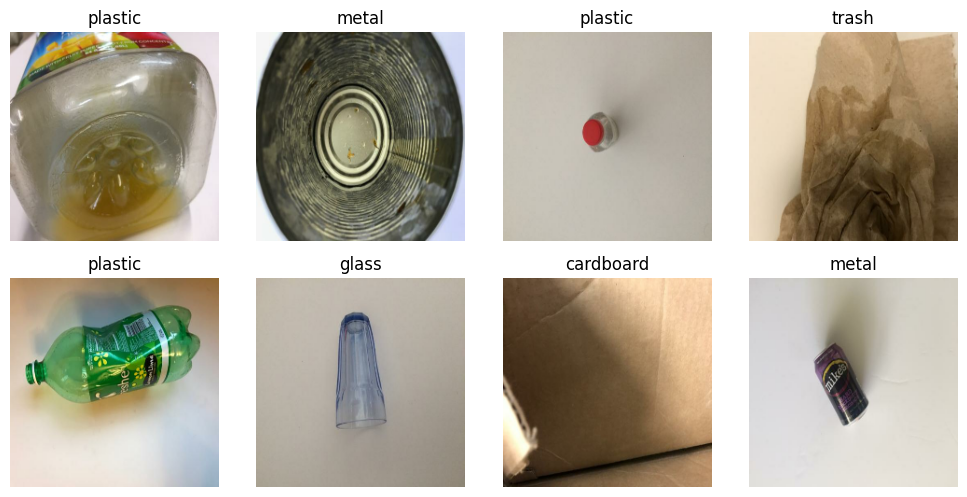

In [13]:
# ======================== Display Sample Images ========================
# Visualizing some of the training images with their labels
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300)  # Save in high definition

In [14]:
# ======================== Build the EcoSort-WastePro Model ========================
# Building a model using EfficientNetV2B1 base
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False   # Freeze this base model to avoid affecting pretrained weights

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
# Constructing the full model
eco_sort_waste_pro = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 1280)     │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,595,194 (28.97 MB)

 Trainable params: 661,510 (2.52 MB)

 Non-trainable params: 6,933,684 (26.45 MB)

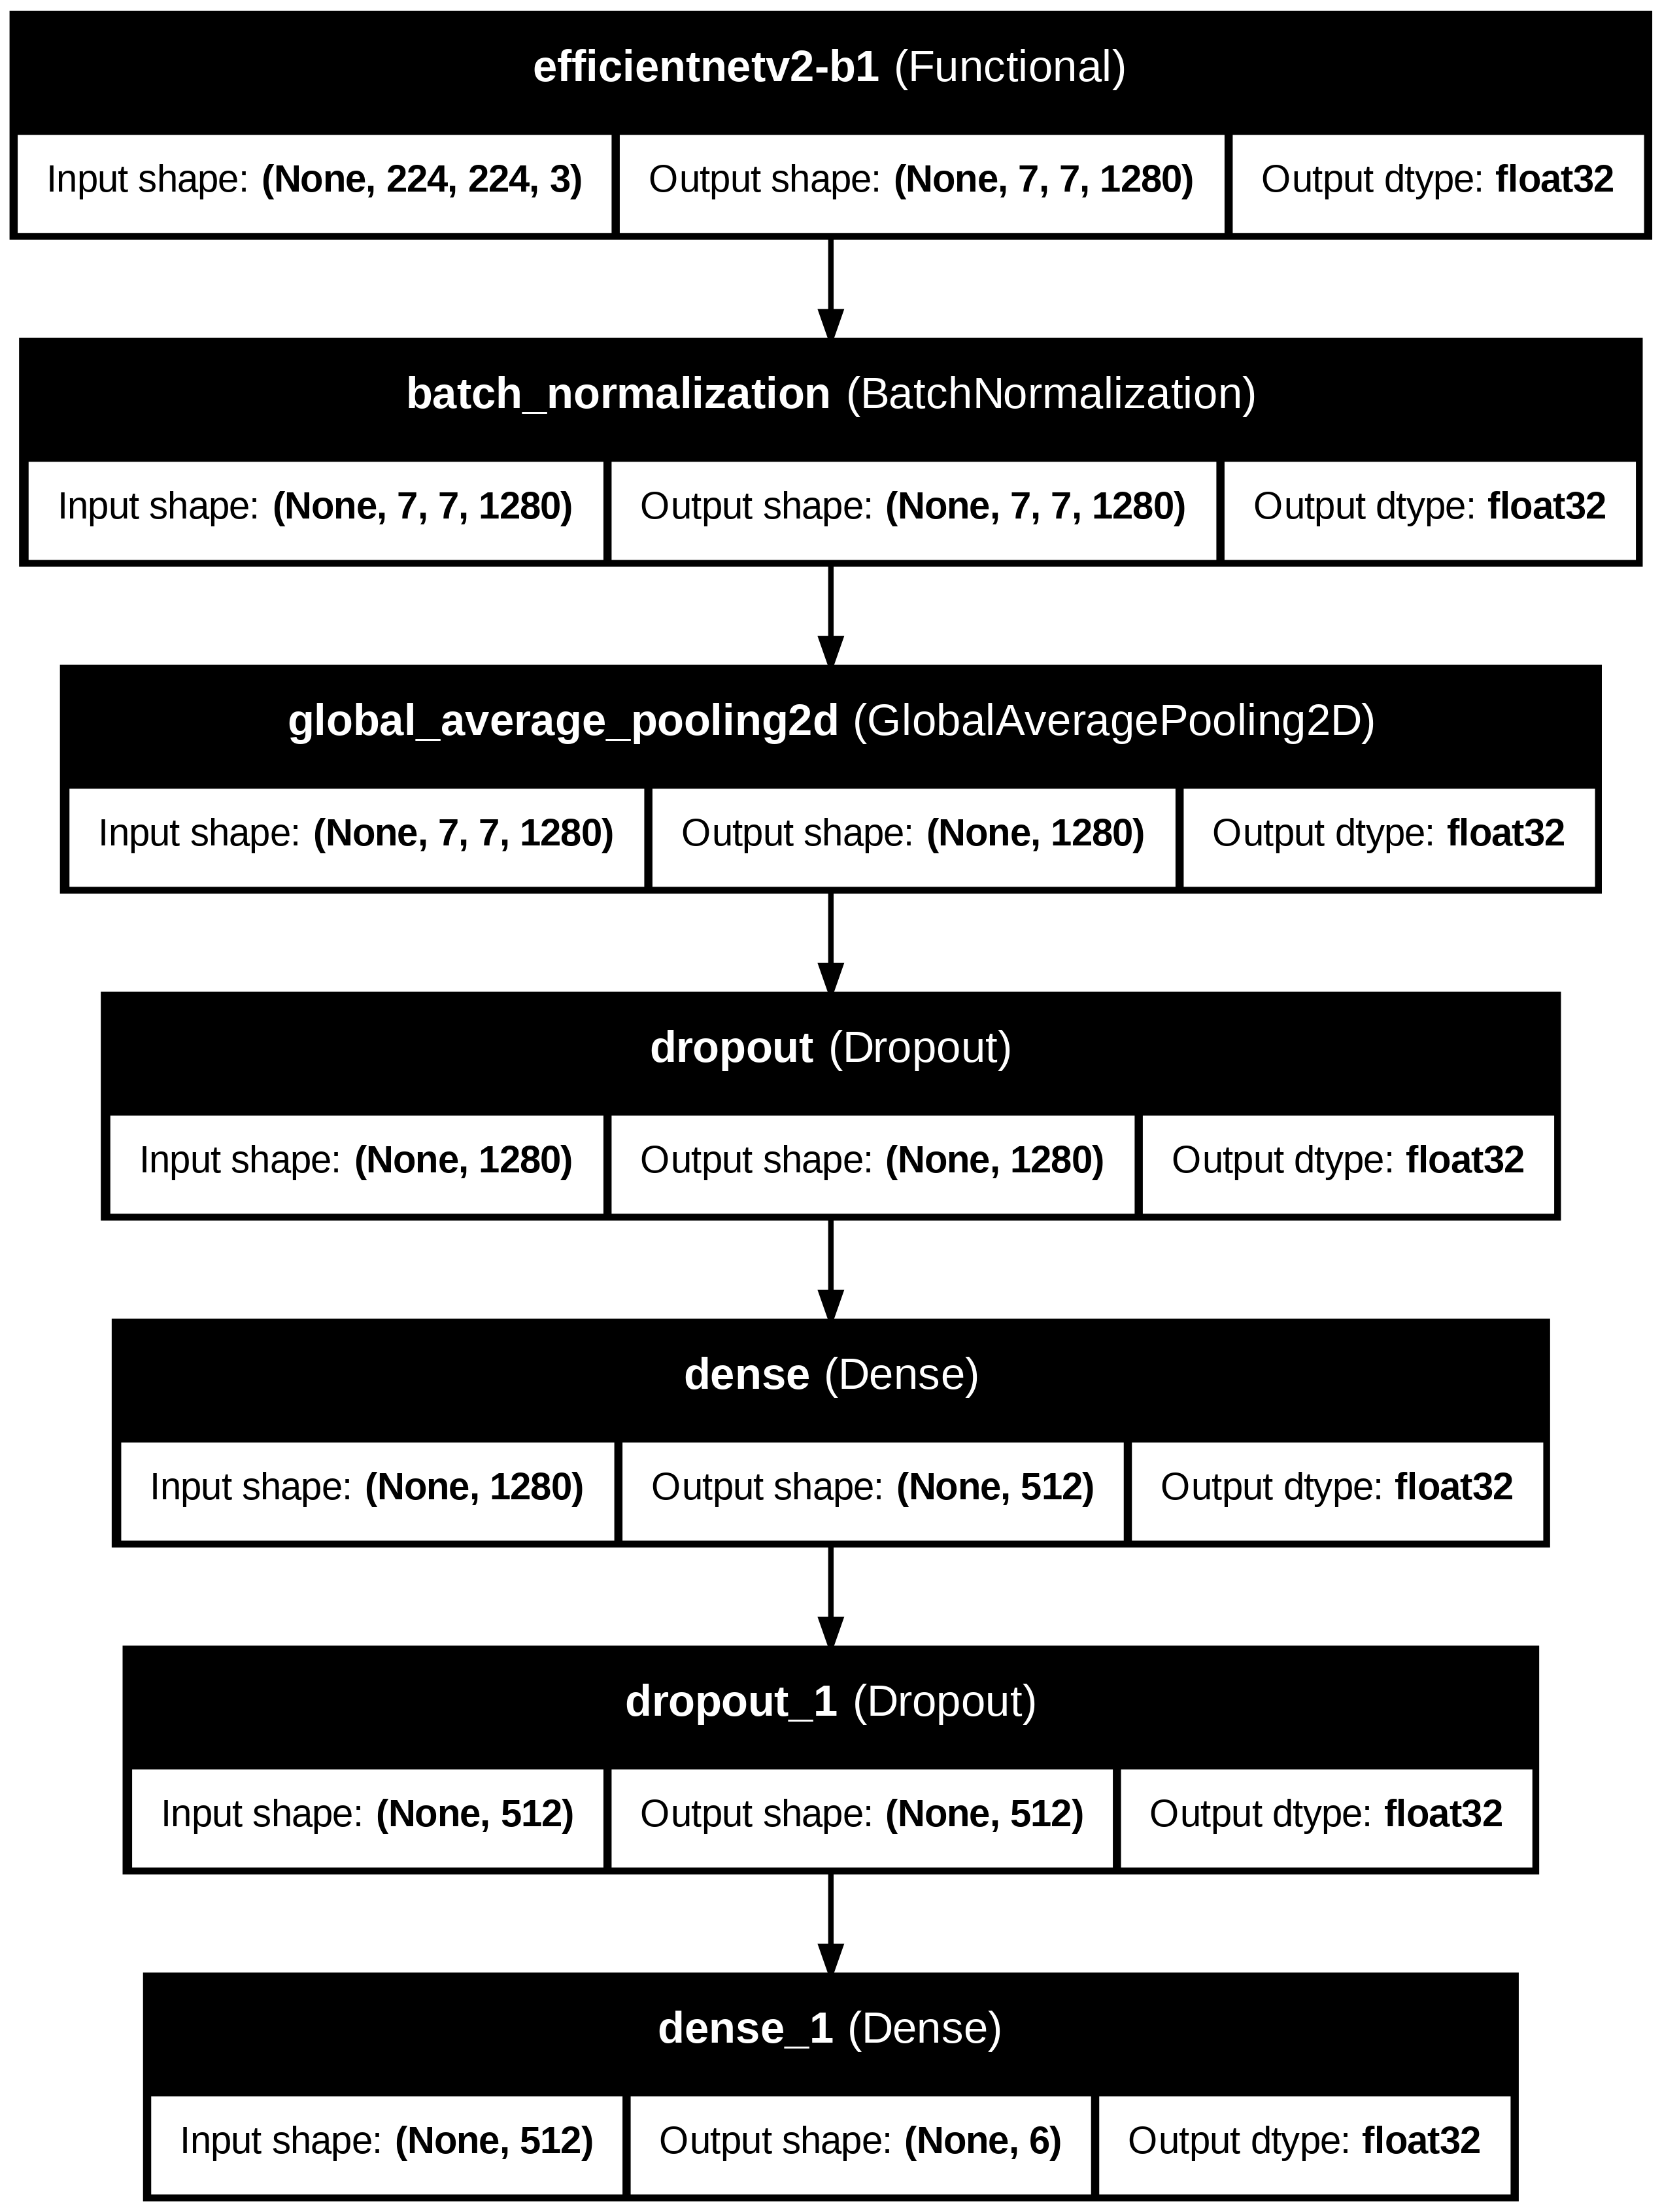

In [16]:
# Display the model architecture
eco_sort_waste_pro.summary()
tf.keras.utils.plot_model(eco_sort_waste_pro, to_file='eco_sort_waste_pro_model.png', show_shapes=True, show_layer_names=True, show_dtype=True, dpi=300)

In [17]:
# ======================== Compile and Train the EcoSort-WastePro Model ========================
# Define callbacks for saving the best model and stopping early if needed
checkpoint = ModelCheckpoint("best_eco_sort_waste_pro_model.keras", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)

In [18]:
# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
eco_sort_waste_pro.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the model
hist = eco_sort_waste_pro.fit(train, epochs=20, validation_data=validation, callbacks=[checkpoint, early_stopping])

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 231s 7s/step - accuracy: 0.5269 - loss: 1.1978 - val_accuracy: 0.8594 - val_loss: 0.4438
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step - accuracy: 0.8541 - loss: 0.4234 - val_accuracy: 0.9129 - val_loss: 0.3228
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.8774 - loss: 0.3512 - val_accuracy: 0.9287 - val_loss: 0.2485
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.8958 - loss: 0.2749 - val_accuracy: 0.9406 - val_loss: 0.2072
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.9158 - loss: 0.2591 - val_accuracy: 0.9525 - val_loss: 0.1687
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 203s 6s/step - accuracy: 0.9193 - loss: 0.2434 - val_accuracy: 0.9604 - val_loss: 0.1469
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 200s 6s/step - accuracy: 0.9296 - loss: 0.1974 - val_accuracy: 0.9723 - val_loss: 0.1267
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 201s 6s/step - accuracy: 0.9284 - loss: 0.1993 - val_accuracy: 0.9723 - v

In [20]:
# Save Training History
hist_df = pd.DataFrame(hist.history)
print("Training History:")
print(hist_df)

Training History:
    accuracy      loss  val_accuracy  val_loss
0   0.677052  0.856760      0.859406  0.443779
1   0.858556  0.412813      0.912871  0.322786
2   0.884273  0.333907      0.928713  0.248542
3   0.902077  0.274454      0.940594  0.207205
4   0.916419  0.258459      0.952475  0.168745
5   0.919881  0.235099      0.960396  0.146867
6   0.928783  0.204761      0.972277  0.126652
7   0.935213  0.189747      0.972277  0.109951
8   0.943126  0.168138      0.974257  0.090772
9   0.946588  0.161973      0.978218  0.087560
10  0.959941  0.134777      0.984158  0.077232
11  0.953511  0.133944      0.982178  0.072146
12  0.959446  0.128109      0.988119  0.067774
13  0.963897  0.121080      0.982178  0.071126
14  0.965381  0.112468      0.988119  0.059544
15  0.965381  0.103273      0.986139  0.060615
16  0.967854  0.103039      0.988119  0.060398
17  0.971316  0.087005      0.988119  0.051516
18  0.975272  0.081518      0.986139  0.052023
19  0.970326  0.083638      0.988119  0.05

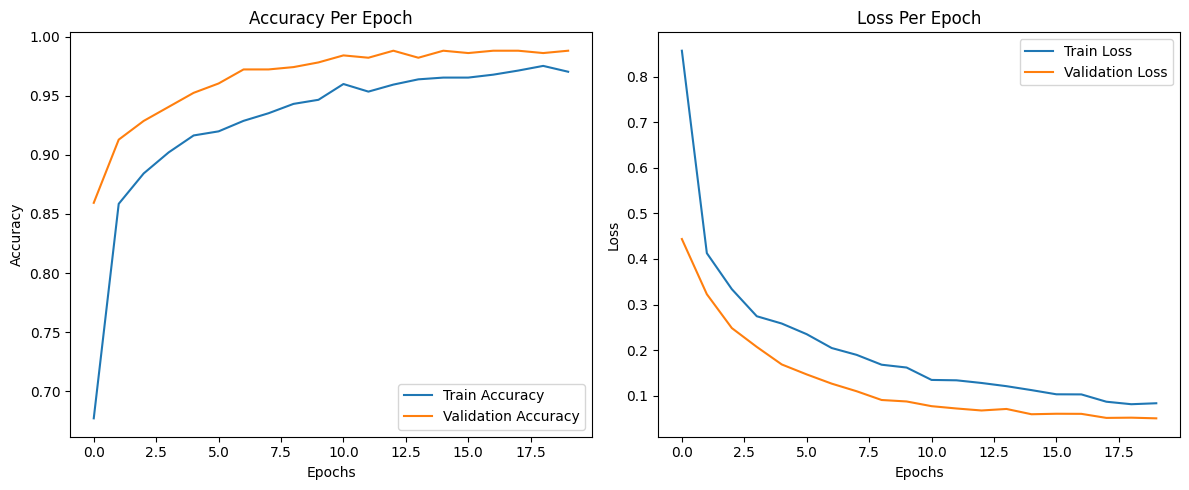

In [21]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Per Epoch')

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Per Epoch')

plt.tight_layout()
plt.savefig('accuracy_loss_per_epoch.png', dpi=300)  # Save in high definition

In [22]:
# ======================== Evaluate EcoSort-WastePro Model on Validation Data ========================
# Prepare validation data for evaluation
X_val, y_val, y_pred = [], [], []
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())

In [23]:
# Get predictions from the model
predictions = eco_sort_waste_pro.predict(np.array(X_val))
y_pred = [np.argmax(i) for i in predictions]

16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


In [24]:
# Create Results DataFrame to compare true labels with predictions
results_df = pd.DataFrame()
results_df['Actual'] = y_val
results_df['Prediction'] = y_pred
print("Predictions vs Actual Labels:")
print(results_df)

Predictions vs Actual Labels:
     Actual  Prediction
0         1           1
1         4           4
2         3           3
3         2           2
4         3           3
..      ...         ...
500       5           5
501       1           1
502       3           3
503       2           2
504       3           3

[505 rows x 2 columns]


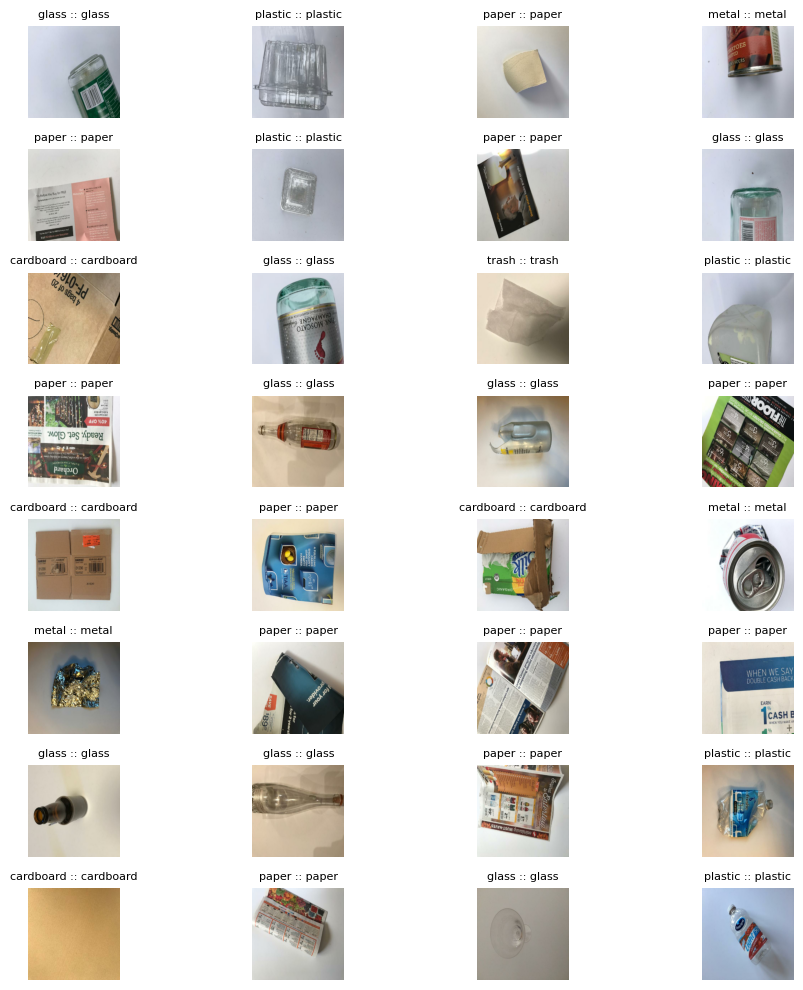

In [25]:
# ======================== Show Images with Predictions ========================
# Visualizing predictions against actual labels
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}', fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.savefig('predictions_vs_actual_images.png', dpi=300)  # Save in high definition


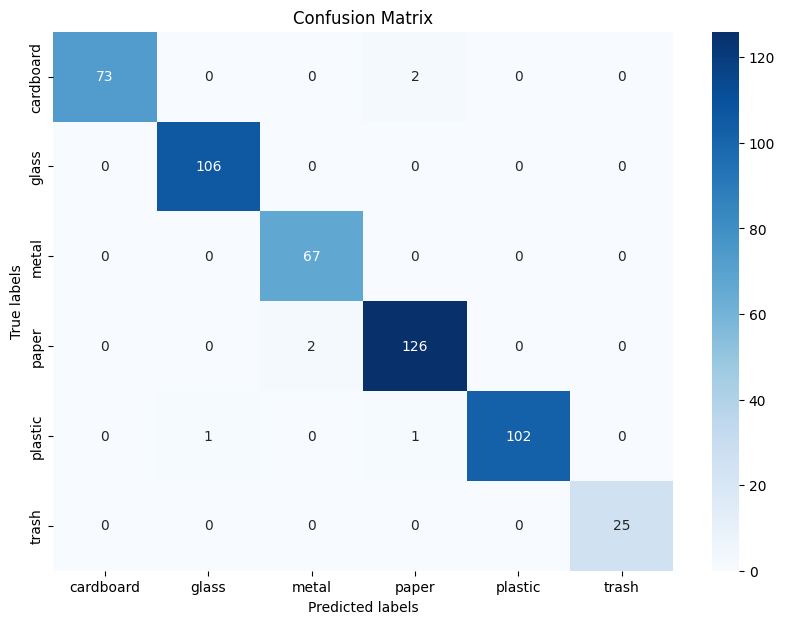

In [26]:
# ======================== Confusion Matrix ========================
# Create confusion matrix to assess model predictions
CM = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(CM, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)  # Save in high definition

In [27]:
# ======================== Metrics Calculation ========================
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

In [28]:
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Validation Accuracy: 98.81%
Precision: 98.83%
Recall: 98.81%
F1 Score: 98.81%


In [29]:
# Generate and display a classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=class_names))



Classification Report:

              precision    recall  f1-score   support

   cardboard       1.00      0.97      0.99        75
       glass       0.99      1.00      1.00       106
       metal       0.97      1.00      0.99        67
       paper       0.98      0.98      0.98       128
     plastic       1.00      0.98      0.99       104
       trash       1.00      1.00      1.00        25

    accuracy                           0.99       505
   macro avg       0.99      0.99      0.99       505
weighted avg       0.99      0.99      0.99       505



In [30]:
# ======================== Save the EcoSort-WastePro Model ========================
# Save the trained model
eco_sort_waste_pro.save('eco_sort_waste_pro_model.keras')
print("EcoSort-WastePro Model Saved Successfully.")

EcoSort-WastePro Model Saved Successfully.
